## Сделки компании N

**Описание данных:**

- client_id - ID клиента;

- sum – сумма денежных средств;

- status – статус оплаты;

- sale – менеджер, заключивший сделку;

- new/current – статус сделки;

- document – наличие оригинала подписанного договора с клиентом;

- receiving_date – дата получения оригинала договора.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime

In [2]:
df = pd.read_excel('data.xlsx')

In [3]:
df.head()

,client_id,sum,status,sale,new/current,Unnamed: 5,document,receiving_date
0,NaN,NaN,Май 2021,NaN,NaN,NaN,NaN,NaN
1,6.0,11693.7,ВНУТРЕННИЙ,-,-,NaN,-,-
2,14.0,5452.7,ОПЛАЧЕНО,Петрова,новая,NaN,оригинал,2021-07-26 00:00:00
3,15.0,13991.7,ОПЛАЧЕНО,Иванов,текущая,NaN,оригинал,2021-06-08 00:00:00
4,16.0,719.7,ОПЛАЧЕНО,Иванов,текущая,NaN,оригинал,2021-06-08 00:00:00


**0) Предобработка данных:**

In [4]:
df.shape

(730, 8)

In [5]:
df = df.drop('Unnamed: 5', 1) # удаление колонки Unnamed: 5

In [6]:
months_name = ['Декабрь', 'Январь', 'Февраль', 'Март', 'Апрель', 'Май', 
                   'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь']  
index_month = []

In [7]:
for index,row in df.iterrows():   # в колонке status написаны месяца, цикл находит индексы этих строк
    for word in months_name:
        if word in str(row['status']):
            index_month.append(index)  # по индексам в index_month будет разделяться df

In [8]:
index_month # значит в данных 6 месяцев начиная с мая

[0, 129, 258, 369, 484, 594]

In [9]:
df.loc[:index_month[1],'pay_month'] = 'May'                # создается столбец с названием месяца
df.loc[index_month[1]:index_month[2],'pay_month'] = 'June'
df.loc[index_month[2]:index_month[3],'pay_month'] = 'July'
df.loc[index_month[3]:index_month[4],'pay_month'] = 'August'
df.loc[index_month[4]:index_month[5],'pay_month'] = 'September'
df.loc[index_month[5]:,'pay_month'] = 'October'

In [10]:
df = df.drop(index_month)  # удаляются строки с названиями месяцев

In [11]:
df.receiving_date = df.receiving_date.replace({'-':np.nan})
df.receiving_date = pd.to_datetime(df.receiving_date, errors='coerce') # приведение колонки к типу datetime

In [12]:
df.dtypes

client_id                float64
sum                      float64
status                    object
sale                      object
new/current               object
document                  object
receiving_date    datetime64[ns]
pay_month                 object
dtype: object

In [13]:
df = df.rename(columns={'sum':'revenue'})  # чтобы колонка не называлась как функция

**1) Вычислите общую выручку за июль 2021 по тем сделкам, приход денежных средств которых не просрочен.**

In [14]:
revenue_july = df.query('status != "ПРОСРОЧЕНО" and pay_month == "July"')['revenue'].sum()

In [15]:
f'Выручка за июль по не просроченным сделкам - {round(revenue_july,2)}'

'Выручка за июль по не просроченным сделкам - 859896.47'

**2) Как изменялась выручка компании за рассматриваемый период? Проиллюстрируйте графиком.**

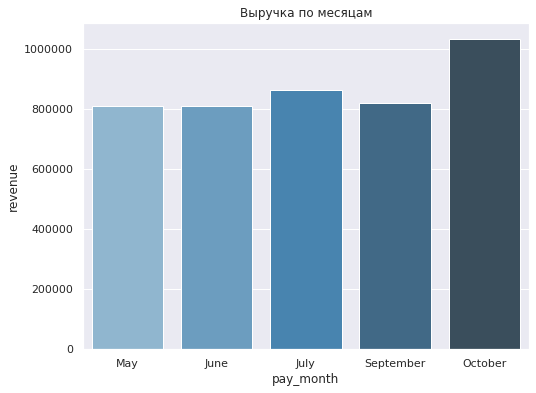

In [16]:
sns.set(rc={'figure.figsize':(8,6)})
sns.barplot(data = df.groupby('pay_month', as_index=False).agg({'revenue':'sum'}),
            x = 'pay_month',
            y = 'revenue',
            palette = 'Blues_d', 
            order = ['May','June','July','September','October']).set_title('Выручка по месяцам');

**3) Кто из менеджеров привлек для компании больше всего денежных средств в сентябре 2021?**

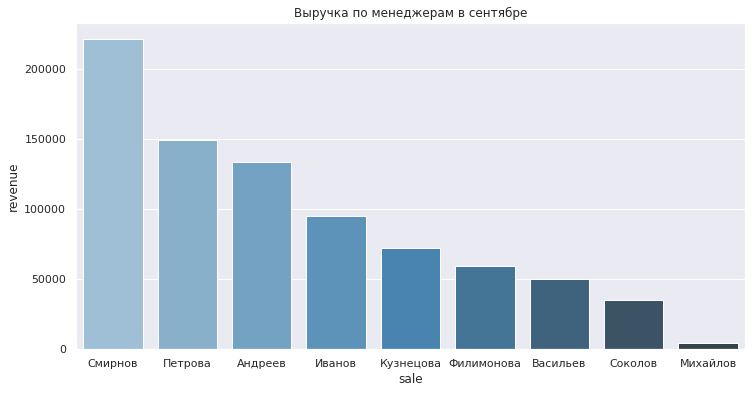

In [17]:
sns.set(rc={'figure.figsize':(12,6)})
sns.barplot(data = df.query('pay_month == "September"').groupby('sale', as_index = False).agg({'revenue':'sum'}).
            sort_values('revenue', ascending=False), 
            x = 'sale', 
            y = 'revenue', 
            palette = 'Blues_d').set_title('Выручка по менеджерам в сентябре');

In [18]:
sale_sep = df.query('pay_month == "September"').groupby('sale', as_index = False). \
            agg({'revenue':'sum'}).sort_values('revenue', ascending=False).head(1)

f'Наибольшая выручка у {sale_sep.iloc[0]["sale"]}: {round(sale_sep.iloc[0]["revenue"],2)}'

'Наибольшая выручка у Смирнов: 221525.7'

**4) Какой тип сделок (новая/текущая) был преобладающим в октябре 2021?**

In [19]:
new_or_curr_oct = df.query('pay_month == "October"').groupby('new/current', as_index=False). \
                    agg({'client_id':'count'}).sort_values('client_id', ascending=False)

In [20]:
f'В октябре преобладают сделки: {new_or_curr_oct.iloc[0]["new/current"]}, их количество: {new_or_curr_oct.iloc[0]["client_id"]}'

'В октябре преобладают сделки: текущая, их количество: 99'

**5) Сколько оригиналов договора по майским сделкам было получено в июне 2021?**

In [21]:
may_to_june = df.query('pay_month == "May" and receiving_date.dt.month == 6')

In [22]:
f'Оригиналов договоров по майским сделкам было получено в июне {may_to_june.shape[0]}'

'Оригиналов договоров по майским сделкам было получено в июне 77'

## Задание

За каждую заключенную сделку менеджер получает бонус, который рассчитывается следующим образом.

1) За новые сделки менеджер получает 7 % от суммы, при условии, что статус оплаты «ОПЛАЧЕНО», а также имеется оригинал подписанного договора с клиентом (в рассматриваемом месяце).

2) За текущие сделки менеджер получает 5 % от суммы, если она больше 10 тыс., и 3 % от суммы, если меньше. При этом статус оплаты может быть любым, кроме «ПРОСРОЧЕНО», а также необходимо наличие оригинала подписанного договора с клиентом (в рассматриваемом месяце). Бонусы по сделкам, оригиналы для которых приходят позже рассматриваемого месяца, считаются остатком на следующий период, который выплачивается по мере прихода оригиналов.

Вычислите остаток каждого из менеджеров на 01.07.2021.

In [23]:
def month_name(row):  # получить название месяца, в котором пришел оригинал договора
    try: 
        return datetime.strftime(row['receiving_date'], "%B")
    except:
        return np.nan

In [24]:
df['receiving_month'] = df.apply(month_name, axis=1) # добавить колонку с месяцем прихода оригинала договора

Необходимо оставить сделки, совершенные до момента 01.07.2021, и с договорами, полученными после 01.07.2021 или не полученными совсем на данный момент:

In [25]:
remains_df = df.query('pay_month in ["May","June"] and receiving_month not in ["May","June"]')

In [26]:
def count_bonus(row):                     # функция расчета размера бонуса
    if row['new/current'] == 'текущая':   
        if row['status'] != 'ПРОСРОЧЕНО':
            if row['revenue'] > 10000:
                return row['revenue']*0.05
            else:
                return row['revenue']*0.03
        else:
            return 0                      # за просроченные сделки бонус не начисляется
                
    elif row['new/current'] == 'новая':   # договора еще нет, но остаток от этих сделок тоже считается
        if row['status'] == 'ОПЛАЧЕНО':
            return row['revenue']*0.07
        else:
            return 0                      # за неоплаченные сделки бонус не начисляется
        
    else:
        return 0 # для внутренних сделок

Далее создать колонку с размером бонуса и посчитать сумму для каждого менеджера:

In [27]:
remains_df['bonus'] = df.apply(count_bonus, axis=1)

/home/alina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Остатки каждого из менеджеров на 01.07.2021:

In [28]:
remains_df.groupby('sale', as_index=False).agg({'bonus':'sum'})

,sale,bonus
0,-,0.0000
1,Андреев,3954.7907
2,Васильев,1037.0490
3,Иванов,5991.4520
4,Кузнецова,4496.9501
5,Петрова,10871.6584
6,Селиванов,5297.6900
7,Смирнов,7401.8220
8,Соколов,269.2110
9,Филимонова,2317.9579
